### RWSE-Checker: true-positives statistics from filtered corpus

In [1]:
from cassis import Cas, load_typesystem
from rwse import RWSE_Checker
from util.helper import collect_sentences_by_confusion_sets, normalize_report, replace_confusion_set_words_in_sentences

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import spacy

/Users/dgardner/GitHub/catalpa-cl/rwse-experiments/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
T_SENTENCE = 'de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Sentence'
T_RWSE = 'de.tudarmstadt.ukp.dkpro.core.api.anomaly.type.RWSE'
T_TOKEN = 'de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Token'

nlp = spacy.load('en_core_web_sm')

path = 'input/TypeSystem.xml'

with open(path, 'rb') as f:
    ts = load_typesystem(f)

S = ts.get_type(T_SENTENCE)
T = ts.get_type(T_TOKEN)

rwse = RWSE_Checker()
rwse.set_confusion_sets('input/confusion_sets_modified.csv')

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls

#### Read from corpus and collect sentences by confusion sets

In [3]:
with open('input/eng_news_2023_10K-sentences.txt', 'r') as f:
    sentences = f.readlines()

sentences_cleaned = [sentence.split('\t')[1].strip() for sentence in sentences]

sentences_by_confusion_sets = collect_sentences_by_confusion_sets(rwse.confusion_sets.values(), sentences_cleaned, nlp)

total = 0
for key, value in sentences_by_confusion_sets.items():
    total += len(value)
    print(key, '=', len(value))

print('total =', total)

Except,accept,except = 21
advice,advise = 21
Effect,affect,effect = 31
Being,begin,being = 214
bitch,pitch = 7
brakes,breaks = 7
Capital,Capitol,capital = 50
Site,sight,site = 30
Country,County,country,county = 135
crab,crap = 2
Desert,desert,dessert = 7
Easy,ease,easy = 32
Effects,affects,effects = 23
extend,extent = 16
feat,feet = 21
Few,View,few,view = 108
Form,From,form,from = 861
Fourth,forth,fourth = 36
forms,forums = 3
Found,Fund,found,fund = 126
Lead,Led,lead,led = 95
Life,Live,life,live = 162
loose,lose = 20
Mad,Made,mad,made = 155
Or,or,ore = 423
Past,passed,past = 81
Peace,Piece,peace,piece = 31
Plain,plain,plane = 12
Principal,principal,principle = 13
Provence,Province,province = 10
Quiet,Quite,quiet,quite = 37
Rise,raise,rise = 36
Safe,Save,safe,save = 50
Split,spit,split = 9
Than,Then,than,then = 433
Their,There,They,their,there,they = 1530
Them,Theme,them,theme = 248
Things,things,thinks = 70
Trail,Trial,trail,trial = 33
Three,Tree,three,tree = 181
To,Too,Two,to,too,two 

#### Switch confusion words in sentences

In [4]:
file_name = 'output/falsified_eng_new_2023_10K-sentences.pkl'

if not os.path.exists(file_name):
    modified_sentences_by_confusion_sets = replace_confusion_set_words_in_sentences(sentences_by_confusion_sets, nlp)
    with open(file_name, 'wb') as f:
        pickle.dump(modified_sentences_by_confusion_sets, f)
else:
    modified_sentences_by_confusion_sets = pickle.load(open(file_name, 'rb'))


total = 0
for key, value in modified_sentences_by_confusion_sets.items():
    total += len(value)
    print(key, '=', len(value))

print('total =', total)

Except,accept,except = 30
advice,advise = 21
Effect,affect,effect = 41
Being,begin,being = 250
bitch,pitch = 7
brakes,breaks = 7
Capital,Capitol,capital = 54
Site,sight,site = 32
Country,County,country,county = 290
crab,crap = 2
Desert,desert,dessert = 11
Easy,ease,easy = 37
Effects,affects,effects = 27
extend,extent = 16
feat,feet = 22
Few,View,few,view = 218
Form,From,form,from = 1838
Fourth,forth,fourth = 44
forms,forums = 3
Found,Fund,found,fund = 258
Lead,Led,lead,led = 194
Life,Live,life,live = 332
loose,lose = 20
Mad,Made,mad,made = 314
Or,or,ore = 454
Past,passed,past = 105
Peace,Piece,peace,piece = 64
Plain,plain,plane = 24
Principal,principal,principle = 16
Provence,Province,province = 10
Quiet,Quite,quiet,quite = 78
Rise,raise,rise = 47
Safe,Save,safe,save = 106
Split,spit,split = 9
Than,Then,than,then = 892
Their,There,They,their,there,they = 7440
Them,Theme,them,theme = 522
Things,things,thinks = 79
Trail,Trial,trail,trial = 68
Three,Tree,three,tree = 368
To,Too,Two,to,too

#### Determine RWSEs

In [5]:
file_name = 'output/report_true_positives.csv'

result = dict()

if not os.path.exists(file_name):
    false_negatives = []
    with open('output/false_negatives.csv', 'w') as f:
        print('confusion_set', 'target', 'masked_sentence', sep='\t', file=f)
        for confusion_set, box in modified_sentences_by_confusion_sets.items():
            rwse.set_confusion_sets([set(confusion_set.split(','))])
            matches = 0
            for item in box:
                cas = Cas(ts)
                sentence = item['sentence']
                # TODO clean sentence?
                cas.sofa_string = sentence
                doc = nlp(cas.sofa_string)
                cas_sentence = S(begin=0, end=len(sentence))
                cas.add(cas_sentence)
                for token in doc:
                    cas_token = T(begin=token.idx, end=token.idx+len(token.text), id=token.i)
                    cas.add(cas_token)
                rwse.check_cas(cas, ts)
                true_positives = cas.select(T_RWSE)
                if len(true_positives) == 0:
                    masked_sentence = sentence[:item['new_token']['begin']] + '[MASK]' + sentence[item['new_token']['end']:]
                    print(confusion_set, item['org_word'], masked_sentence, sep='\t', file=f)
                else:
                    matches += 1
            result[confusion_set] = {
                'num_sentences':len(box),
                'num_matches':matches,
            }

    with open(file_name, 'w') as f:
        print('confusion_set', 'num_matches', 'num_sentences', sep=';', file=f)
        for key, value in result.items():
            print(key, value['num_matches'], value['num_sentences'], sep=';', file=f)
else:
    with open(file_name, 'r') as f:
        for line in f.readlines()[1:]:
            confusion_set, num_matches, num_sentences = line.strip().split(';')
            print(confusion_set, num_matches, num_sentences, sep='\t', end='\n')
            result[confusion_set] = {'num_matches': int(num_matches), 'num_sentences': int(num_sentences)}

#### Determine Sensitivity (True-Positive-Rate)

In [6]:
total = sum(item['num_sentences'] for item in result.values())
total_matches = sum(item['num_matches'] for item in result.values())
print(f'true positive rate: {total_matches/total:.3f}')
print(f'correctly identified {total_matches} out of {total}')

true positive rate: 0.986
correctly identified 44256 out of 44893


<Axes: xlabel='confusion_set'>

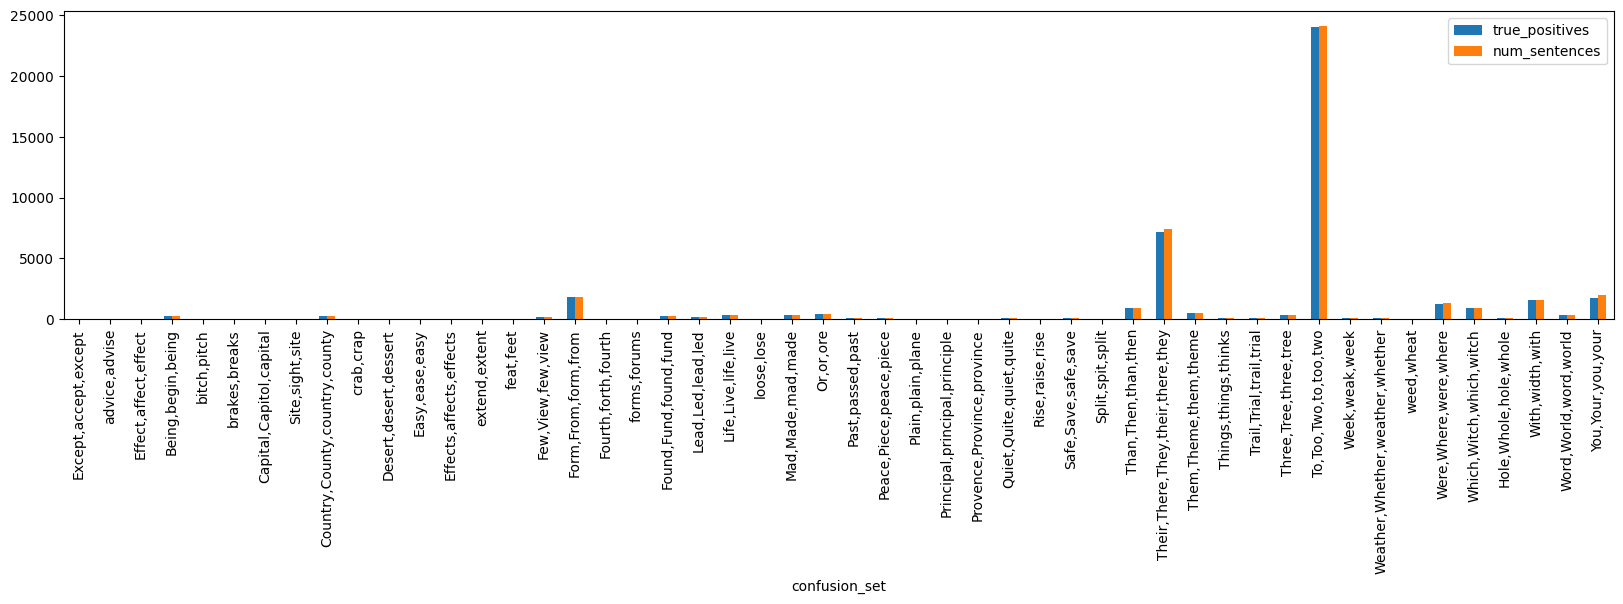

In [7]:
tp_df = pd.read_csv('output/report_true_positives.csv', sep=';')#[['confusion_set', 'num_sentences']]
tp_df.columns = ['confusion_set', 'true_positives', 'num_sentences']
tp_df.index = tp_df['confusion_set']
tp_df.plot(kind="bar", figsize=(20,4))

#### Determine Mean Sensitivity

In [8]:
file_name = 'output/report_true_positives.csv'

data_mean_sensitivity = normalize_report(file_name)

mean_sensitivity = sum(data_mean_sensitivity.values())/ len(data_mean_sensitivity)

print(f'Mean Sensitivity = {mean_sensitivity:.10f}')

Mean Sensitivity = 0.9667071014


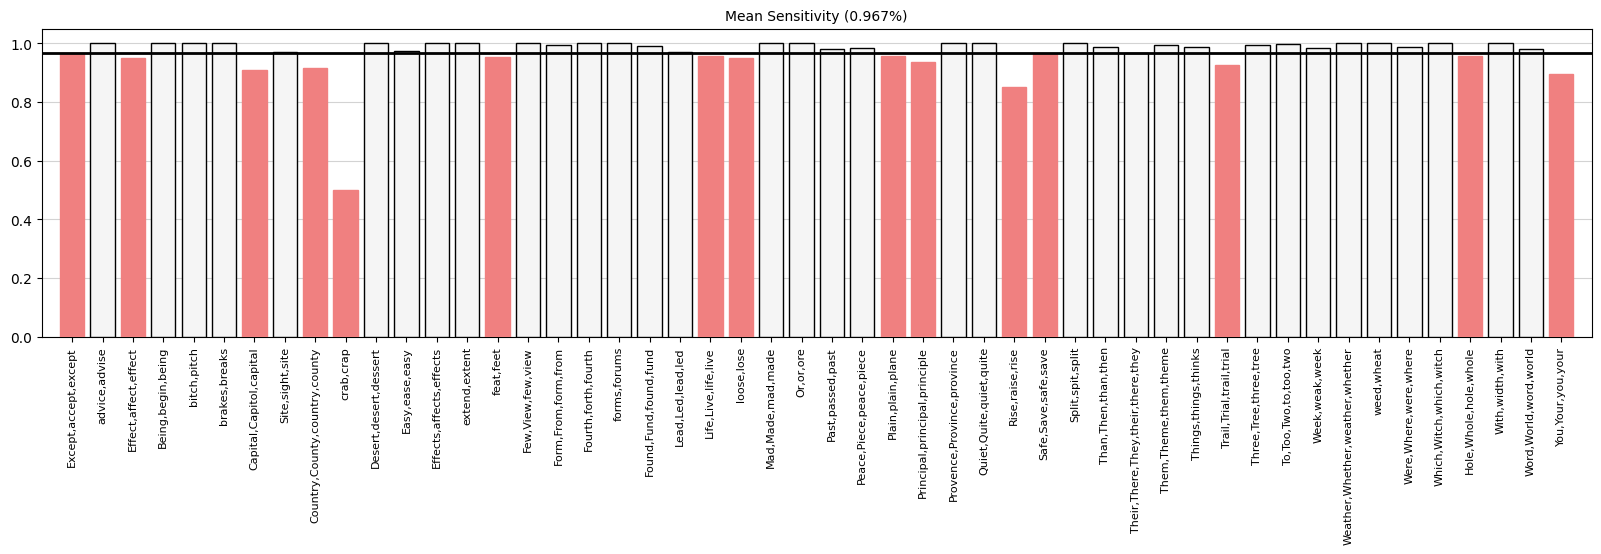

In [9]:
xticks = list(range(len(data_mean_sensitivity)))
values = list(data_mean_sensitivity.values())
labels = list(data_mean_sensitivity.keys())

fig, ax = plt.subplots(figsize=(20,4))
ax.set_title(f"Mean Sensitivity ({mean_sensitivity:.3f}%)", fontsize=10)
bars = ax.bar(xticks, values, zorder=3, color="whitesmoke", edgecolor="black", linewidth=1, align="center")
for idx, value in enumerate(values):
    if value < mean_sensitivity:
        bars[idx].set_color('lightcoral')
#ax.plot(xticks,[mean_sensitivity]*len(xticks), zorder=3, color="black", linewidth=1)
ax.set_xticks(xticks, labels, rotation='vertical')
ax.xaxis.set_tick_params(labelsize=8)
ax.grid(color='lightgray', axis="y", zorder=0)
ax.margins(x=0) # removes white space surrounding bars

x = np.linspace(-1, len(data_mean_sensitivity))
y = [mean_sensitivity]*len(x)
ax.plot(x, y, zorder=3, color="black", linewidth=2)

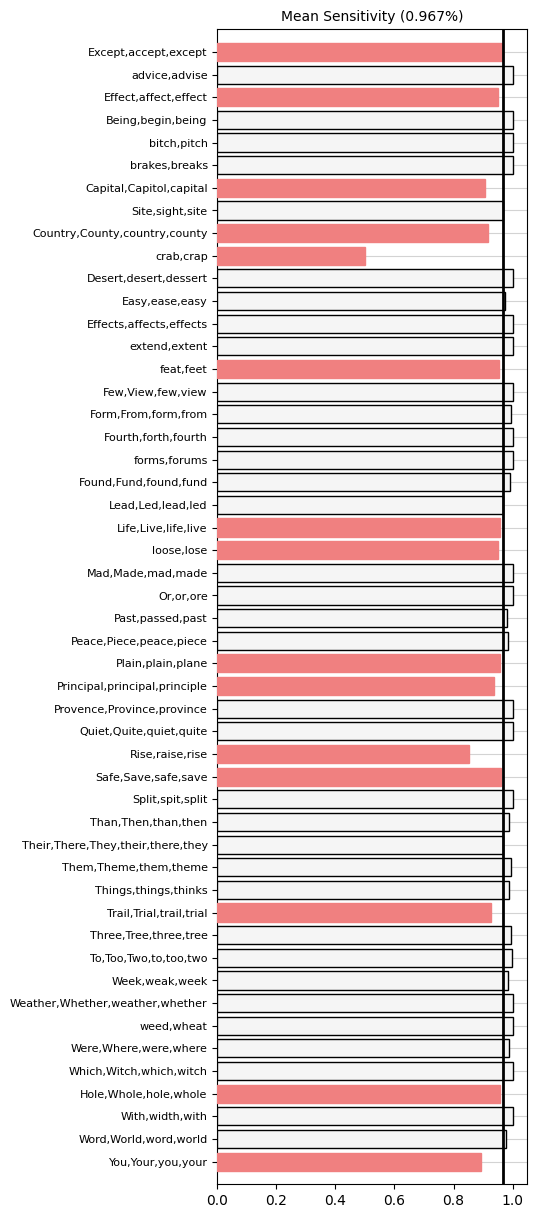

In [10]:
yticks = list(range(len(data_mean_sensitivity)))
values = list(data_mean_sensitivity.values())
labels = list(data_mean_sensitivity.keys())

values.reverse()
labels.reverse()

fig, ax = plt.subplots(figsize=(4,15))
ax.set_title(f"Mean Sensitivity ({mean_sensitivity:.3f}%)", fontsize=10)
bars = ax.barh(yticks, values, zorder=3, color="whitesmoke", edgecolor="black", linewidth=1, align="center")
for idx, value in enumerate(values):
    if value < mean_sensitivity:
        bars[idx].set_color('lightcoral')
ax.set_yticks(yticks, labels, rotation='horizontal')
ax.yaxis.set_tick_params(labelsize=8)
ax.grid(color='lightgray', axis="y", zorder=0)
ax.margins(y=0)

x = [mean_sensitivity]*len(x)
y = np.linspace(-1, len(data_mean_sensitivity))
ax.plot(x, y, zorder=3, color="black", linewidth=2)